# Feature engineering from volume

We're going to use non-linear models to make more accurate predictions. With linear models, features must be linearly correlated to the target. Other machine learning models can combine features in non-linear ways. For example, what if the price goes up when the moving average of price is going up, and the moving average of volume is going down? The only way to capture those interactions is to either multiply the features, or to use a machine learning algorithm that can handle non-linearity (e.g. random forests).

In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pandas_datareader import DataReader
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9,8]

In [2]:
ticker = 'ITSA4.SA'
data_source = 'yahoo'
start = datetime(2016, 1, 1)
end = datetime(2019,12, 31)

itau = DataReader(ticker,data_source, start, end)
itau = itau.sort_values(by='Date')
itau.drop(columns=['High','Low', 'Open', 'Close'], inplace=True)
itau.loc[itau['Volume'] == 0, 'Volume'] = (itau['Volume'].shift(-1) + itau['Volume'].shift(1))/2

In [3]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
itau['5d_future_close'] = itau['Adj Close'].shift(-5)
itau['5d_close_future_pct'] = itau['5d_future_close'].pct_change(5)
itau['5d_close_pct'] = itau['Adj Close'].pct_change(5)

In [4]:
import talib

feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close
    itau['ma' + str(n)] = talib.SMA(itau['Adj Close'].values,
                              timeperiod=n) / itau['Adj Close']
    # Create the RSI indicator
    itau['rsi' + str(n)] = talib.RSI(itau['Adj Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

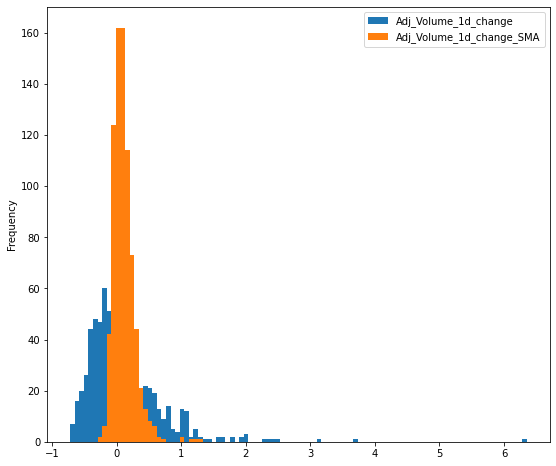

In [5]:
itau = itau.dropna()
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
itau['Adj_Volume_1d_change'] = itau['Volume'].pct_change()
itau['Adj_Volume_1d_change_SMA'] = talib.SMA(itau['Adj_Volume_1d_change'].values,
                        timeperiod=5)

# Plot histogram of volume % change data
itau[new_features].plot(kind='hist', sharex=False, bins=100)
plt.show()

We can see the moving average of volume changes has a much smaller range than the raw data.

# Create day-of-week features

We can engineer datetime features to add even more information for our non-linear models. Most financial data has datetimes, which have lots of information in them -- year, month, day, and sometimes hour, minute, and second. But we can also get the day of the week, and things like the quarter of the year, or the elapsed time since some event (e.g. earnings reports).

In [6]:
import pandas as pd

# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(itau.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = itau.index

# Join the dataframe with the days of week dataframe
itau = pd.concat([itau, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
itau.dropna(inplace=True)  # drop missing values in-place
print(itau.head())

                Volume  Adj Close  5d_future_close  5d_close_future_pct  \
Date                                                                      
2016-10-27  26441704.0   6.347233         6.473474             0.019889   
2016-10-28  20988910.0   6.361258         6.627775             0.041897   
2016-10-31  37790425.0   6.620756         6.662838             0.006356   
2016-11-01  28602337.0   6.473474         6.522571             0.007584   
2016-11-03  22765539.0   6.347233         6.185918            -0.025415   

            5d_close_pct      ma14      rsi14      ma30      rsi30      ma50  \
Date                                                                           
2016-10-27     -0.003303  0.985872  61.200658  0.958342  58.624012  0.955019   
2016-10-28      0.006658  0.986455  61.818571  0.958582  58.910724  0.953502   
2016-10-31      0.053571  0.952255  71.016318  0.924930  63.722445  0.917395   
2016-11-01      0.044117  0.977558  61.901800  0.949152  59.622997  0.9392

# Examine correlations of the new features

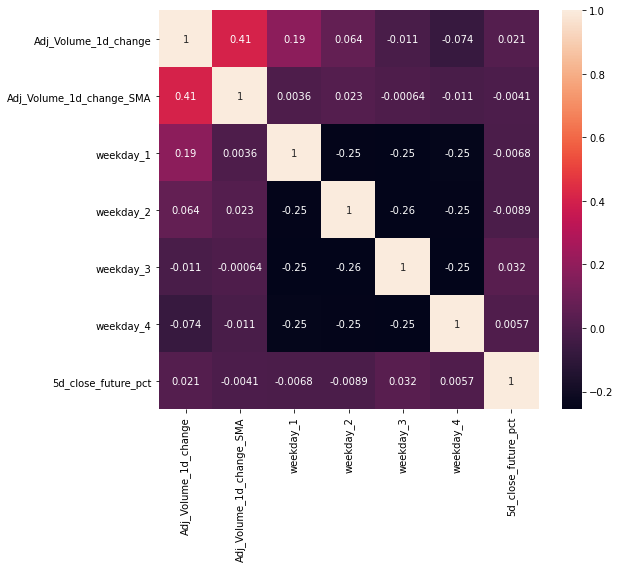

In [7]:
import seaborn as sns

# Add the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(itau[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

Even though the correlations are weak, they may improve our predictions via interactions with other features.

# Fit a decision tree

Random forests are a go-to model for predictions; they work well out of the box. But we'll first learn the building block of random forests -- decision trees.

Decision trees split the data into groups based on the features. Decision trees start with a root node, and split the data down until we reach leaf nodes.

In [8]:
from sklearn.tree import DecisionTreeRegressor

# Create a size for the training set that is 85% of the total number of samples
features = itau.iloc[:,4:]
targets = itau['5d_close_future_pct']
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

In [9]:
# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

1.0
-2.484668321475889


# Try different max depths

We always want to optimize our machine learning models to make the best predictions possible. We can do this by tuning hyperparameters, which are settings for our models. We will see in more detail how these are useful in future chapters, but for now think of them as knobs we can turn to tune our predictions to be as good as possible.

In [10]:
# Loop through a few different max depths and check the performance
for d in [3, 5, 10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.15775415078685417
-0.20672459375459495 

max_depth= 5
0.340091349605098
-0.20763371495416383 

max_depth= 10
0.9098192420144945
-2.12992159698057 



# Check our results

Once we have an optimized model, we want to check how it is performing in more detail. We already saw the R² score, but it can be helpful to see the predictions plotted vs actual values.

Ideally, we want to see diagonal lines from the lower left to the upper right. However, due to the simplicity of decisions trees, our model is not going to do well on the test set. But it will do well on the train set.

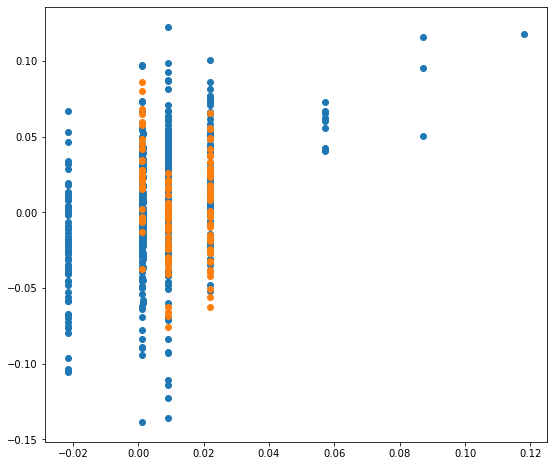

In [11]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.show()

# Fit a random forest

Data scientists often use random forest models. They perform well out of the box, and have lots of settings to optimize performance. Random forests can be used for classification or regression; we'll use it for regression to predict the future price change of Itaú.

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9094397142772028
-0.36940373048436714


# Tune random forest hyperparameters

In [13]:
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators':[200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.06664576434808844 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


# Evaluate performance

Lastly, and as always, we want to evaluate performance of our best model to check how well or poorly we are doing. Ideally it's best to do back-testing. Perfect predictions would be a diagonal line from the lower left to the upper right.

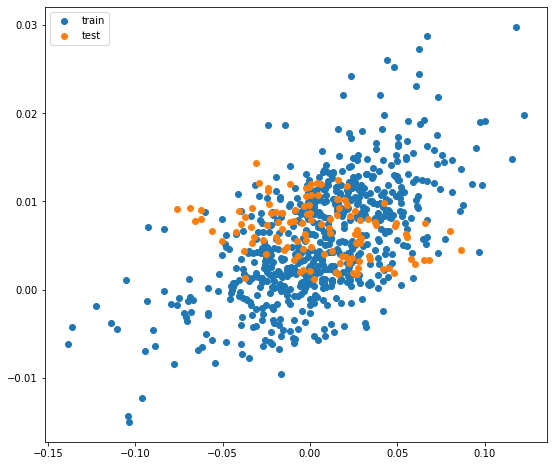

In [14]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

# Random forest feature importances

One useful aspect of tree-based methods is the ability to extract feature importances. This is a quantitative way to measure how much each feature contributes to our predictions. It can help us focus on our best features, possibly enhancing or tuning them, and can also help us get rid of useless features that may be cluttering up our model.

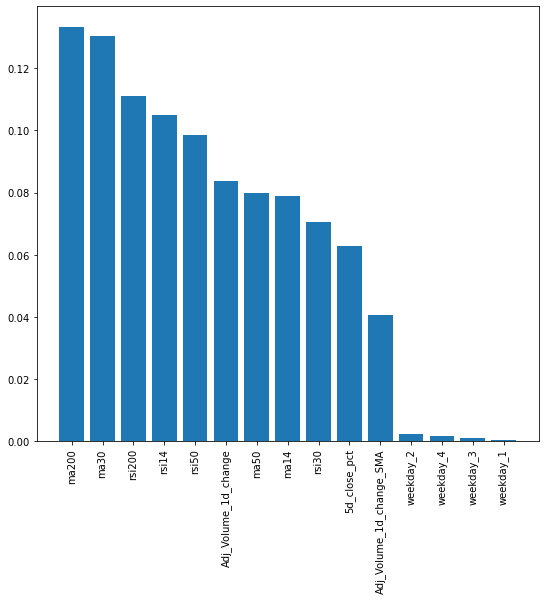

In [15]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

# A gradient boosting model

GB is similar to random forest models, but the difference is that trees are built successively. With each iteration, the next tree fits the residual errors from the previous tree in order to improve the fit.

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.2724926065392945
-0.08344154633498868


# Gradient boosting feature importances

As with random forests, we can extract feature importances from gradient boosting models to understand which features are the best predictors. Sometimes it's nice to try different tree-based models and look at the feature importances from all of them. This can help average out any peculiarities that may arise from one particular model.

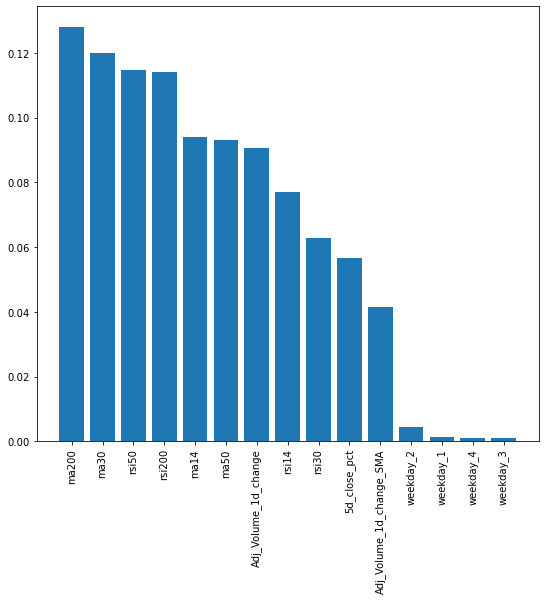

In [17]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(features.shape[1])

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()